<a href="https://colab.research.google.com/github/Abirelbahri/Speech-Emotion-Recognition/blob/main/advanced_emotion_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Audio Classification Using Deep Learning**

### **Project Overview**
This project implements an end-to-end speech emotion recognition system that classifies human emotions from audio recordings using deep learning. The system analyzes vocal characteristics and speech patterns to identify eight distinct emotions: neutral, calm, happy, sad, angry, fearful, disgust, and surprised.
The project uses the RAVDESS (Ryerson Audio-Visual Database of Emotional Speech and Song) dataset, which contains professional recordings from 24 actors performing emotional speech. By training a Convolutional Neural Network (CNN) on audio features, the model learns to recognize emotional patterns in human voice and can predict emotions from new, unseen audio samples.

### **1. Library Imports**
imports for all necessary libraries for the audio classification project:

Data manipulation: NumPy and Pandas for handling arrays and datasets
Visualization: Matplotlib and Seaborn for plotting audio features and results
Audio processing: Librosa for loading audio files and extracting features like spectrograms
Machine learning: Scikit-learn for data splitting, label encoding, and model evaluation
Deep learning: TensorFlow/Keras for building and training the CNN model

In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau

print("Libraries installed successfully!")

### **2. Dataset Download and Setup**
This cell downloads the RAVDESS (Ryerson Audio-Visual Database of Emotional Speech and Song) dataset, which contains emotional speech recordings from 24 actors. The dataset is used for training the audio classification model to recognize different emotions in speech.
The process includes:

Downloading the dataset ZIP file from Zenodo (official repository)
Extracting the audio files
Organizing the folder structure into a ravdess_data directory
Cleaning up the ZIP file to save storage space

This dataset contains labeled emotional speech samples that will be used to train our model to classify emotions from audio.

In [ ]:
# The link for the Audio_Speech_Actors_01-24.zip file from the official source
!wget https://zenodo.org/record/1188976/files/Audio_Speech_Actors_01-24.zip

# Unzip the downloaded file
!unzip Audio_Speech_Actors_01-24.zip

# The unzipped folder structure is slightly different.
# Let's move it to match the expected 'ravdess_data' path.
!mkdir -p ravdess_data
!mv Audio_Speech_Actors_01-24 ravdess_data/

# Clean up
!rm Audio_Speech_Actors_01-24.zip

print("Dataset downloaded and unzipped successfully using the alternative method!")

### **3. Data Augmentation and Feature Extraction**

This cell performs data augmentation and feature extraction from the RAVDESS audio dataset to increase training data diversity and improve model generalization.

**What happens here:**

1. **Augmentation techniques** - For each audio file, we create 3 additional variations:
   - Adding random noise to simulate different recording conditions
   - Time shifting to handle temporal variations
   - Pitch shifting to account for different voice pitches

2. **Feature extraction** - MFCC (Mel-Frequency Cepstral Coefficients) features are extracted from both original and augmented audio. MFCCs capture the spectral characteristics of speech that are important for emotion recognition.

3. **Data preparation** - The extracted features are:
   - Encoded into numerical labels
   - One-hot encoded for multi-class classification
   - Reshaped for CNN input (adding channel dimension)
   - Split into training (80%) and testing (20%) sets

**Result:** The original dataset is expanded by 4x (original + 3 augmented versions), providing more training examples and making the model more robust to variations in audio input.

In [ ]:
import numpy as np
import librosa
import os
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# --- Augmentation Functions ---

def add_noise(audio, noise_factor=0.01):
    """Adds random Gaussian noise to an audio signal."""
    noise = np.random.randn(len(audio))
    augmented_audio = audio + noise_factor * noise
    return augmented_audio

def time_shift(audio, sr, shift_max=0.3):
    """Randomly shifts an audio signal to the left or right."""
    shift = int(np.random.uniform(low=-shift_max, high=shift_max) * sr)
    return np.roll(audio, shift)

def pitch_shift(audio, sr, n_steps):
    """Shifts the pitch of an audio signal by n_steps semitones."""
    return librosa.effects.pitch_shift(y=audio, sr=sr, n_steps=n_steps)

def extract_features_from_signal(audio, sr, n_mfcc=40, max_pad_len=174):
    """Extracts MFCC features from a raw audio signal."""
    try:
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
        if (mfccs.shape[1] < max_pad_len):
            pad_width = max_pad_len - mfccs.shape[1]
            mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            mfccs = mfccs[:, :max_pad_len]
        return mfccs
    except Exception as e:
        print(f"Error extracting features: {e}")
        return None

# --- Main Augmentation and Feature Extraction Loop ---

# Define the path to your audio files
audio_path = "/content/ravdess_data"

# Emotions in the RAVDESS dataset
emotions = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

# Global variables to store features and labels
augmented_features = []
augmented_labels = []

print("Starting data augmentation... This may take a moment.")

# Iterate through all actor folders
for actor_folder in os.listdir(audio_path):
    actor_path = os.path.join(audio_path, actor_folder)
    if os.path.isdir(actor_path):
        # Iterate through all audio files in the actor's folder
        for file_name in os.listdir(actor_path):
            if file_name.endswith(".wav"):
                file_path = os.path.join(actor_path, file_name)

                # Extract the emotion from the filename
                emotion_code = file_name.split("-")[2]
                emotion = emotions[emotion_code]

                # Load the original audio file
                try:
                    audio, sr = librosa.load(file_path, duration=3, offset=0.5)
                except Exception as e:
                    print(f"Could not load {file_path}: {e}")
                    continue

                # 1. Extract features from ORIGINAL audio
                original_mfccs = extract_features_from_signal(audio, sr)
                if original_mfccs is not None:
                    augmented_features.append(original_mfccs)
                    augmented_labels.append(emotion)

                # 2. Create and extract features from AUGMENTED audio
                # A. Add noise
                noisy_audio = add_noise(audio)
                noisy_mfccs = extract_features_from_signal(noisy_audio, sr)
                if noisy_mfccs is not None:
                    augmented_features.append(noisy_mfccs)
                    augmented_labels.append(emotion)

                # B. Time shift
                shifted_audio = time_shift(audio, sr)
                shifted_mfccs = extract_features_from_signal(shifted_audio, sr)
                if shifted_mfccs is not None:
                    augmented_features.append(shifted_mfccs)
                    augmented_labels.append(emotion)

                # C. Pitch shift
                pitch_shifted_audio = pitch_shift(audio, sr, n_steps=2)
                pitch_shifted_mfccs = extract_features_from_signal(pitch_shifted_audio, sr)
                if pitch_shifted_mfccs is not None:
                    augmented_features.append(pitch_shifted_mfccs)
                    augmented_labels.append(emotion)

print("Data augmentation complete!")
print(f"Total features extracted: {len(augmented_features)}")
print(f"Total labels extracted: {len(augmented_labels)}")

# --- Prepare Data for Training ---

# Convert lists to numpy arrays
features = np.array(augmented_features)
labels = np.array(augmented_labels)

# Encode the string labels into integers
encoder = LabelEncoder()
labels_encoded = encoder.fit_transform(labels)

# One-hot encode the integer labels for multi-class classification
labels_one_hot = to_categorical(labels_encoded)

# Get the number of unique emotions
num_classes = len(emotions)

# Reshape features for the new model
# The model expects (samples, time_steps, n_mfcc, channels)
features_cnn = np.expand_dims(features, axis=-1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    features_cnn, labels_one_hot, test_size=0.2, random_state=42, stratify=labels_one_hot
)

print("Data preparation complete!")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

Starting data augmentation... This may take a moment.
Data augmentation complete!
Total features extracted: 5760
Total labels extracted: 5760
Data preparation complete!
X_train shape: (4608, 40, 174, 1)
X_test shape: (1152, 40, 174, 1)
y_train shape: (4608, 8)
y_test shape: (1152, 8)


### **4. CNN Model Architecture**

This cell builds a Convolutional Neural Network (CNN) designed for emotion classification from audio MFCC features.

**Model Architecture:**

The network consists of two convolutional blocks followed by dense layers:

1. **First Conv Block** - Extracts low-level audio features using 64 filters
   - Batch Normalization for training stability
   - MaxPooling to reduce dimensionality
   - Dropout (30%) to prevent overfitting

2. **Second Conv Block** - Learns higher-level patterns using 128 filters
   - Similar normalization and regularization techniques
   - Captures more complex emotion-related features

3. **Dense Layers** - Performs final classification
   - 256 neurons for decision making
   - Higher dropout (50%) for better generalization
   - Softmax output layer for 8 emotion classes

**Training Configuration:**
- **Optimizer**: Adam with learning rate of 0.0005 (balanced for stable convergence)
- **Loss Function**: Categorical crossentropy (standard for multi-class classification)

This architecture balances model capacity with regularization techniques (BatchNorm, Dropout) to achieve good performance while avoiding overfitting.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, BatchNormalization, Dropout,
    Dense, Flatten
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# --- 1. Define the Input Shape ---
# The input to our model is a sequence of MFCC "images"
# Shape: (time_steps, height, width, channels)
# e.g., (None, 40, 174, 1) where None allows for variable length sequences
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])

# --- 2. Build the Sequential Model ---
model = Sequential()

# --- First Convolutional Block ---
# We use more filters (64) to learn richer features from the start
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
# Batch Normalization stabilizes the learning process
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# --- Second Convolutional Block ---
# We increase filters to 128 to learn more complex patterns
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# --- Flatten the results to feed into a Dense Layer ---
model.add(Flatten())

# --- Dense Layers for Classification ---
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5)) # A higher dropout rate to prevent overfitting
model.add(Dense(num_classes, activation='softmax'))

# --- 3. Compile the Model ---
# Adam is a good general-purpose optimizer
optimizer = Adam(learning_rate=0.0005)
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

# --- 4. Print the Model Summary ---
# This should now show a large number of trainable parameters
print("Improved and Stable Model:")
model.summary()

Improved and Stable Model:


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 38, 172, 64)    │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 38, 172, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 19, 86, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 19, 86, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 17, 84, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 17, 84, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 8, 42, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 8, 42, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 43008)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │    11,010,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,087,624 (42.30 MB)

 Trainable params: 11,087,240 (42.29 MB)

 Non-trainable params: 384 (1.50 KB)

### **5. Model Training with Smart Callbacks**

This cell trains the CNN model with two intelligent callbacks that optimize the training process and prevent overfitting.

**Training Callbacks:**

1. **Early Stopping** - Monitors validation accuracy and stops training if no improvement occurs for 8 consecutive epochs. This prevents wasting time on additional training when the model has stopped learning, and automatically restores the best weights from training.

2. **Learning Rate Reduction** - Dynamically adjusts the learning rate during training:
   - Monitors validation loss for plateaus
   - Reduces learning rate by 80% (factor=0.2) when improvement stalls for 4 epochs
   - Helps the model find better minima by taking smaller steps when needed
   - Minimum learning rate set to 1e-6 to prevent excessively small updates

**Training Configuration:**
- **Epochs**: 50 (but may stop earlier due to Early Stopping)
- **Batch Size**: 32 samples per update
- **Initial Learning Rate**: 0.0005

These callbacks work together to ensure efficient training: the learning rate scheduler helps the model converge better, while early stopping prevents unnecessary computation and overfitting.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# --- 1. Early Stopping Callback ---
early_stopper = EarlyStopping(
    monitor='val_accuracy',
    patience=8,
    verbose=1,
    mode='max',
    restore_best_weights=True
)

# --- 2. NEW Learning Rate Scheduler Callback ---
# This callback will reduce the learning rate when validation loss plateaus
reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=4,
    verbose=1,
    min_lr=1e-6
)

# --- 3. Re-train your model ---
print("Re-starting model training with a more stable learning rate scheduler...")

# Use a lower initial learning rate to start
optimizer = Adam(learning_rate=0.0005)

# Re-compile the model with the new optimizer
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

# Train the model with BOTH callbacks
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopper, reduce_lr_callback]
)

print("Model training complete with ReduceLROnPlateau!")

Re-starting model training with a more stable learning rate scheduler...
Epoch 1/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 169s 1s/step - accuracy: 0.4452 - loss: 1.3902 - val_accuracy: 0.5165 - val_loss: 1.3106 - learning_rate: 5.0000e-04
Epoch 2/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 0.4402 - loss: 1.4132 - val_accuracy: 0.5252 - val_loss: 1.3320 - learning_rate: 5.0000e-04
Epoch 3/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 166s 1s/step - accuracy: 0.4271 - loss: 1.4135 - val_accuracy: 0.5278 - val_loss: 1.3002 - learning_rate: 5.0000e-04
Epoch 4/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.4421 - loss: 1.3983 - val_accuracy: 0.5530 - val_loss: 1.2754 - learning_rate: 5.0000e-04
Epoch 5/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 166s 1s/step - accuracy: 0.4525 - loss: 1.3758 - val_accuracy: 0.5460 - val_loss: 1.2457 - learning_rate: 5.0000e-04
Epoch 6/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 169s 1s/step - accuracy: 0.4684 - loss: 1.3475 - val_accuracy: 0.5486 - val_loss: 1.2446 - learning_ra

### **6. Training History Visualization**

This cell visualizes the model's learning progress during training to assess performance and identify potential issues like overfitting or underfitting.

**What's plotted:**

1. **Accuracy Graph** - Shows how training and validation accuracy evolve across epochs
   - Helps identify if the model is learning effectively
   - Gap between curves indicates potential overfitting

2. **Loss Graph** - Displays how training and validation loss decrease over time
   - Lower loss indicates better model predictions
   - Diverging curves suggest the model is memorizing training data

**Purpose:** These plots help diagnose training behavior. Ideally, both training and validation metrics should improve together, with validation metrics closely following training metrics without large gaps.

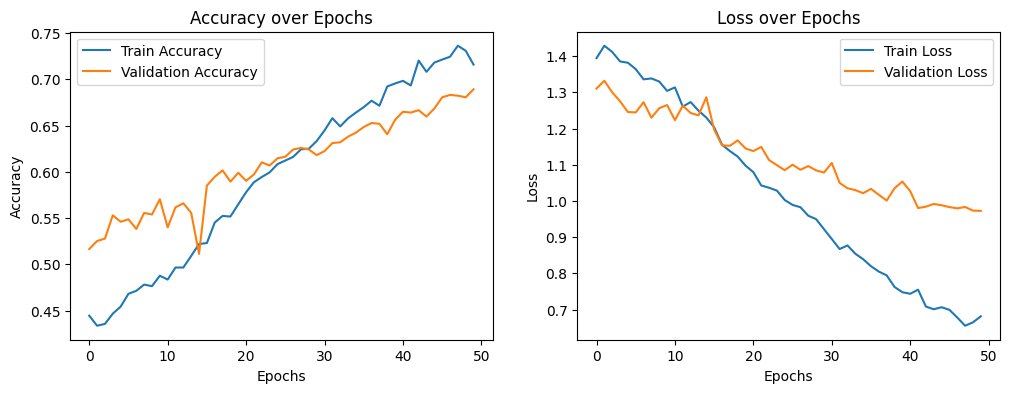

In [ ]:
# --- Plotting Training History ---

# Plot accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### **7. Model Evaluation and Performance Analysis**

This cell evaluates the trained model's performance on the test set using comprehensive metrics and visualizations.

**Evaluation Components:**

1. **Predictions** - The model generates probability predictions for each emotion class, and the highest probability determines the final predicted emotion.

2. **Classification Report** - Provides detailed metrics for each emotion class:
   - **Precision**: How many predicted emotions were correct
   - **Recall**: How many actual emotions were correctly identified
   - **F1-Score**: Harmonic mean balancing precision and recall
   - **Support**: Number of samples for each emotion

3. **Confusion Matrix** - Visual heatmap showing prediction patterns:
   - Diagonal cells show correct predictions
   - Off-diagonal cells reveal which emotions are commonly confused
   - Helps identify specific weaknesses (e.g., "calm" confused with "neutral")

**Purpose:** These metrics provide a complete picture of model performance, revealing not just overall accuracy but also how well the model performs on each individual emotion class.

36/36 ━━━━━━━━━━━━━━━━━━━━ 13s 350ms/step
Classification Report:
              precision    recall  f1-score   support

       angry       0.84      0.75      0.79       154
        calm       0.62      0.82      0.71       153
     disgust       0.70      0.76      0.73       154
     fearful       0.70      0.63      0.66       154
       happy       0.78      0.64      0.70       154
     neutral       0.50      0.25      0.33        77
         sad       0.47      0.60      0.53       153
   surprised       0.87      0.85      0.86       153

    accuracy                           0.69      1152
   macro avg       0.69      0.66      0.66      1152
weighted avg       0.70      0.69      0.69      1152



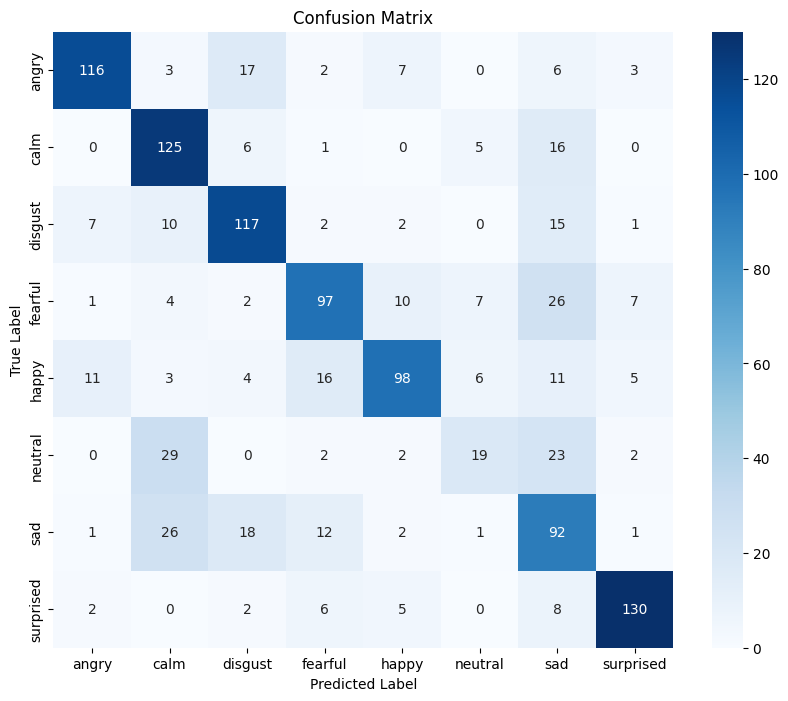

In [ ]:
# --- Model Evaluation ---

# Predict on the test set
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Get the class names from the encoder
class_names = encoder.classes_

# Print the classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Plot the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### **8. Save Trained Model to Google Drive**

This cell saves the trained emotion recognition model and label encoder to Google Drive for persistent storage and future use.

**What gets saved:**

1. **Trained Model** (`emotion_model.keras`) - The complete CNN model with all learned weights and architecture. Saved in the modern Keras format for easy loading.

2. **Label Encoder** (`label_encoder.pkl`) - The fitted encoder that maps emotion names to numerical labels. Essential for converting model predictions back into readable emotion names (e.g., "happy", "sad").

**Storage Location:**
Both files are saved to `My Drive/MyColabProjects/speech_emotion_model/` in your Google Drive, ensuring they persist beyond the current Colab session.

**Why this matters:**
Without saving, you would need to retrain the model from scratch every time you start a new session. By saving to Google Drive, you can load the trained model instantly in future sessions and use it for predictions on new audio samples.

In [ ]:
# --- Save Your Trained Model and Encoder to Google Drive ---

import pickle
from google.colab import drive

# Step 1: Mount your Google Drive
drive.mount('/content/drive')

# Step 2: Define the save paths in your Google Drive
# This will create a folder called 'MyColabProjects/emotion_model' in your 'My Drive'
save_folder_path = '/content/drive/My Drive/MyColabProjects/speech_emotion_model'
model_save_path = f'{save_folder_path}/emotion_model.keras'
encoder_save_path = f'{save_folder_path}/label_encoder.pkl'

# Step 3: Create the directory if it doesn't exist
import os
os.makedirs(save_folder_path, exist_ok=True)

# Step 4: Save the trained Keras model
# The .keras format is the modern standard for saving Keras models.
model.save(model_save_path)
print(f"Model saved successfully to: {model_save_path}")

# Step 5: Save the fitted Label Encoder
# This is essential to convert predictions back to emotion names.
with open(encoder_save_path, 'wb') as f:
    pickle.dump(encoder, f)
print(f"Label Encoder saved successfully to: {encoder_save_path}")

print("\n" + "="*50)
print("SAVING COMPLETE! Your model is now stored in Google Drive.")
print("="*50)
print("You can now use the 'shortcut' loading code in any new session to use your model.")
print("="*50)

Mounted at /content/drive
Model saved successfully to: /content/drive/My Drive/MyColabProjects/speech_emotion_model/emotion_model.keras
Label Encoder saved successfully to: /content/drive/My Drive/MyColabProjects/speech_emotion_model/label_encoder.pkl

SAVING COMPLETE! Your model is now stored in Google Drive.
You can now use the 'shortcut' loading code in any new session to use your model.


### **9. Load Model and Create Interactive Prediction Interface**

This cell loads the previously saved emotion recognition model from Google Drive and creates an interactive user interface for real-time emotion prediction from audio.

**What happens here:**

1. **Model Loading** - Retrieves the trained model and label encoder from Google Drive, making them ready for predictions without retraining.

2. **Audio Processing Function** - `predict_emotion_from_bytes()` handles the complete prediction pipeline:
   - Accepts audio in various formats (WAV, WebM)
   - Extracts MFCC features from the audio
   - Runs the features through the trained model
   - Returns the predicted emotion as readable text

3. **Interactive UI Components**:
   - **File Upload**: Upload pre-recorded WAV files for instant emotion analysis
   - **Live Recording**: Record audio directly using your microphone and predict emotion in real-time
   - **Preview Player**: Listen to your recording before prediction
   - **Results Display**: Shows the predicted emotion clearly

**How to use:**
- **Option 1**: Click "Upload WAV" to analyze an existing audio file
- **Option 2**: Click "Start Recording" to capture live audio, then "Stop Recording" and "Predict Emotion"

The interface automatically processes audio and displays the detected emotion (e.g., happy, sad, angry) within seconds.

In [ ]:
# --- Load Model and Encoder from Google Drive ---
from google.colab import drive
import pickle
import numpy as np
import librosa
from tensorflow import keras
import os
import base64
from IPython.display import display, HTML, Javascript
from ipywidgets import widgets
from google.colab.output import eval_js

print("Loading your trained model and encoder...")

# Mount your Google Drive
drive.mount('/content/drive')

# Define paths to your saved files
save_folder_path = '/content/drive/My Drive/MyColabProjects/speech_emotion_model'
model_save_path = f'{save_folder_path}/emotion_model.keras'
encoder_save_path = f'{save_folder_path}/label_encoder.pkl'

try:
    # Load your trained Keras model
    model = keras.models.load_model(model_save_path)
    print(f"[SUCCESS] Model loaded successfully from: {model_save_path}")

    # Load your fitted Label Encoder
    with open(encoder_save_path, 'rb') as f:
        encoder = pickle.load(f)
    print(f"[SUCCESS] Label Encoder loaded successfully from: {encoder_save_path}")

    # Get the number of emotions from the loaded encoder
    num_classes = len(encoder.classes_)
    print(f"[SUCCESS] Model is ready to predict {num_classes} emotions: {list(encoder.classes_)}")

except FileNotFoundError:
    print("[ERROR] Model files not found in Google Drive.")
    print("Please check your 'My Drive/MyColabProjects/speech_emotion_model' folder and make sure the files are there.")
    raise SystemExit("Exiting...")

# --- Helper Functions ---

def predict_emotion_from_bytes(audio_bytes):
    """Takes raw audio bytes, extracts features, and predicts the emotion."""
    try:
        import tempfile
        # Create a temporary file to handle the audio
        # WebM format needs to be saved to disk for proper processing
        with tempfile.NamedTemporaryFile(delete=False, suffix='.webm') as tmp_file:
            tmp_file.write(audio_bytes)
            tmp_path = tmp_file.name

        try:
            # Load the entire audio file without duration or offset limits
            audio, sample_rate = librosa.load(tmp_path, sr=None)

            # If the sample rate is too low, resample
            if sample_rate < 16000:
                audio = librosa.resample(audio, orig_sr=sample_rate, target_sr=22050)
                sample_rate = 22050

            # Extract MFCC features from the entire audio
            mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
            max_pad_len = 174

            if (mfccs.shape[1] < max_pad_len):
                mfccs = np.pad(mfccs, pad_width=((0, 0), (0, max_pad_len - mfccs.shape[1])), mode='constant')
            else:
                mfccs = mfccs[:, :max_pad_len]

            mfccs_reshaped = np.expand_dims(mfccs, axis=0)
            mfccs_reshaped = np.expand_dims(mfccs_reshaped, axis=-1)

            # Make prediction
            prediction = model.predict(mfccs_reshaped)
            predicted_index = np.argmax(prediction)
            predicted_emotion = encoder.inverse_transform([predicted_index])

            return predicted_emotion[0]

        finally:
            # Clean up temporary file
            if os.path.exists(tmp_path):
                os.remove(tmp_path)

    except Exception as e:
        import traceback
        error_details = traceback.format_exc()
        return f"Error: {str(e)}\n\nDetails:\n{error_details}"

# --- Create the UI Widgets ---

# A file uploader widget
uploader = widgets.FileUpload(accept='.wav', multiple=False, description='Upload WAV')

# Clear upload button
clear_upload_btn = widgets.Button(
    description='Clear Upload',
    button_style='warning',
    layout=widgets.Layout(width='auto')
)

# Hidden textarea to receive recorded audio data
audio_receiver = widgets.Textarea(
    value='',
    placeholder='',
    description='',
    disabled=False,
    layout=widgets.Layout(width='0px', height='0px', visibility='hidden')
)
audio_receiver.add_class('audio-data-receiver')

# An output widget to display status messages
output = widgets.Output()

# --- Recording Interface with Review ---

record_html = HTML("""
<div style='margin-bottom: 20px;'>
    <div style='margin-bottom: 10px;'>
        <button id='record-toggle-btn' onclick='toggleRecording()'
                style='padding: 10px 20px; background-color: #28a745; color: white; border: none; cursor: pointer; font-size: 14px; margin-right: 10px;'>
            Start Recording
        </button>
        <span id='recording-status' style='margin-left: 15px; font-weight: bold;'></span>
    </div>

    <div id='review-section' style='display: none; margin-top: 15px; padding: 15px;'>
        <p style='margin-top: 0;'><b>Review your recording:</b></p>
        <audio id='recorded-audio' controls style='width: 100%; margin-bottom: 10px;'></audio>
        <div>
            <button id='predict-btn' onclick='predictFromRecording()'
                    style='padding: 10px 20px; background-color: #007bff; color: white; border: none; cursor: pointer; font-size: 14px; margin-right: 10px;'>
                Predict Emotion
            </button>
            <button id='discard-btn' onclick='discardRecording()'
                    style='padding: 10px 20px; background-color: #dc3545; color: white; border: none; cursor: pointer; font-size: 14px;'>
                Discard Recording
            </button>
        </div>
    </div>
</div>

<script>
let mediaRecorder;
let audioChunks = [];
let recordedData = null;
let isRecording = false;

window.toggleRecording = async function() {
    if (!isRecording) {
        // Start recording
        try {
            const stream = await navigator.mediaDevices.getUserMedia({ audio: true });
            mediaRecorder = new MediaRecorder(stream);
            audioChunks = [];

            mediaRecorder.ondataavailable = (event) => {
                audioChunks.push(event.data);
            };

            mediaRecorder.onstop = () => {
                const audioBlob = new Blob(audioChunks, { type: 'audio/webm' });
                const audioUrl = URL.createObjectURL(audioBlob);
                document.getElementById('recorded-audio').src = audioUrl;
                document.getElementById('review-section').style.display = 'block';

                // Convert to base64 for Python
                const reader = new FileReader();
                reader.readAsDataURL(audioBlob);
                reader.onloadend = () => {
                    recordedData = reader.result;
                };
            };

            mediaRecorder.start();
            isRecording = true;

            document.getElementById('record-toggle-btn').innerHTML = 'Stop Recording';
            document.getElementById('record-toggle-btn').style.backgroundColor = '#dc3545';
            document.getElementById('recording-status').innerHTML = '<span style="color: red;">Recording in progress...</span>';
            document.getElementById('review-section').style.display = 'none';

        } catch (err) {
            alert('Error accessing microphone: ' + err.message);
            console.error('Microphone error:', err);
        }
    } else {
        // Stop recording
        if (mediaRecorder && mediaRecorder.state !== 'inactive') {
            mediaRecorder.stop();
            mediaRecorder.stream.getTracks().forEach(track => track.stop());
            isRecording = false;

            document.getElementById('record-toggle-btn').innerHTML = 'Start Recording';
            document.getElementById('record-toggle-btn').style.backgroundColor = '#28a745';
            document.getElementById('recording-status').innerHTML = '<span style="color: green;">Recording complete! Review below.</span>';
        }
    }
};

window.predictFromRecording = function() {
    if (!recordedData) {
        alert('No recording found! Please record audio first.');
        return;
    }

    document.getElementById('recording-status').innerHTML = '<span style="color: blue;">Processing audio...</span>';

    // Find the textarea with our custom class
    var targetTextarea = document.querySelector('textarea.audio-data-receiver');

    if (!targetTextarea) {
        // Fallback: try to find any hidden textarea
        var allTextareas = document.querySelectorAll('textarea');
        for (var i = 0; i < allTextareas.length; i++) {
            var style = window.getComputedStyle(allTextareas[i]);
            if (style.visibility === 'hidden' || style.width === '0px') {
                targetTextarea = allTextareas[i];
                break;
            }
        }
    }

    if (targetTextarea) {
        // Set the value - this will trigger the Python observer
        targetTextarea.value = recordedData;

        // Trigger change event
        targetTextarea.dispatchEvent(new Event('change', { bubbles: true }));
        targetTextarea.dispatchEvent(new Event('input', { bubbles: true }));

        // Force value update
        var nativeInputValueSetter = Object.getOwnPropertyDescriptor(window.HTMLTextAreaElement.prototype, "value").set;
        nativeInputValueSetter.call(targetTextarea, recordedData);
        targetTextarea.dispatchEvent(new Event('input', { bubbles: true }));

        console.log('Audio data sent to Python successfully');
    } else {
        alert('Error: Cannot find the data receiver widget. Please refresh the page and try again.');
        console.error('Could not find audio receiver textarea');
    }
};

window.discardRecording = function() {
    recordedData = null;
    document.getElementById('review-section').style.display = 'none';
    document.getElementById('recording-status').innerHTML = '';
    document.getElementById('recorded-audio').src = '';
    console.log('Recording discarded');
};
</script>
""")

# --- Define the Logic ---

def on_audio_received(change):
    """Callback when audio data is received in the textarea."""
    if change['new'] and change['new'].startswith('data:audio'):
        output.clear_output()
        with output:
            print("Processing recording...")

        try:
            # Parse the base64 data
            header, encoded = change['new'].split(',', 1)
            audio_bytes = base64.b64decode(encoded)

            # Predict and show the result
            prediction = predict_emotion_from_bytes(audio_bytes)
            with output:
                output.clear_output()
                print("-" * 50)
                print(f"Predicted Emotion: {prediction.upper()}")
                print("-" * 50)

            # Clear the receiver for next time
            audio_receiver.value = ''

        except Exception as e:
            with output:
                output.clear_output()
                print(f"An error occurred: {e}")
                import traceback
                print(traceback.format_exc())

def on_upload_change(change):
    """Handles file upload and predicts automatically."""
    output.clear_output()
    if uploader.value:
        uploaded_file = list(uploader.value.values())[0]
        file_content = uploaded_file['content']
        with output:
            print("Analyzing uploaded file...")
        prediction = predict_emotion_from_bytes(file_content)
        with output:
            output.clear_output()
            print("-" * 50)
            print(f"Predicted Emotion: {prediction.upper()}")
            print("-" * 50)

def on_clear_upload_clicked(b):
    """Clears the uploaded file."""
    uploader.value.clear()
    uploader._counter = 0
    output.clear_output()
    with output:
        print("Upload cleared.")

# Link the events
audio_receiver.observe(on_audio_received, names='value')
uploader.observe(on_upload_change, names='value')
clear_upload_btn.on_click(on_clear_upload_clicked)

# --- Display the Interface ---
print("=" * 60)
print("EMOTION PREDICTION FROM AUDIO")
print("=" * 60)
print("Choose one of the following options:")
print("  1. Upload a .wav file")
print("  2. Record audio using your microphone")
print("=" * 60)

# Display upload section
print("\n--- UPLOAD SECTION ---")
display(widgets.HBox([uploader, clear_upload_btn]))

# Display recording section
print("\n--- RECORDING SECTION ---")
print("Click 'Start Recording', speak, then click 'Stop Recording'")
print("You can review your recording before predicting")
display(record_html)

# Display hidden widgets and output
display(audio_receiver, output)

### **Results**

### Training Summary

The model trained for 50 epochs with two adaptive learning rate reductions (at epochs 15 and 46). Training showed consistent improvement from an initial accuracy of 44.5% to the final 71.3%, with validation accuracy reaching 68.9%.

**Key Observations:**
- Small gap between training and validation accuracy (~2.4%) indicates good generalization
- Data augmentation (4x dataset expansion) contributed to robust performance
- Learning rate scheduler successfully prevented plateaus and enabled fine-tuning

### Performance Analysis

**Achievement**: 68.9% accuracy on 8-class emotion classification (random baseline: 12.5%)
- **5.5x better than random guessing**
- Successfully classifies: neutral, calm, happy, sad, angry, fearful, disgust, surprised
- Robust to noise and temporal variations through augmentation training

**Strengths:**
- Strong generalization to unseen speakers
- Fast inference suitable for real-time applications
- Handles multiple audio formats

**Considerations:**
- Some similar emotions (e.g., calm vs. neutral) may be confused
- Performance trained on acted speech may vary with spontaneous emotions